# **Data Preparation**

Load the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random



Prepare the feature table
  

1.   Load in the feature table
2.   Load in the sample ids
3.   Prepare the list of QC samples (coming from the same person)
4.   Replace the sample id column with real sample IDs



In [ ]:
#features = pd.read_parquet('feature_table_50.parquet')
ids = pd.read_csv('sample_ids.csv')

ids['filename'] = ids['filename'].str.replace(".mzML","") # Remove the .mzML suffix from the filenames
ids['sample_id'] = ids['sample_id'].str.replace(" ","") # Remove the empty spaces from the sample_Ids

qc_ids = ids[ids['sample_id'].str.contains('QC',na=False)] # Select only the sample Ids with QC in the name + Negative Controls
qc_ids = qc_ids['sample_id'].tolist() # Convert to list, that can be iterated on later
qc_ids

['LCMS_QC3',
 'LCMS_QC_3',
 'LCMS_QC_1',
 'LCMS_QC_2',
 'LCMS_QC_3',
 'LCMS_QC_1',
 'LCMS_QC_2',
 'LCMS_QC1',
 'LCMS_QC3',
 'LCMS_QC2',
 'LCMS_QC_2',
 'LCMS_QC_1',
 'LCMS_QC1',
 'LCMS_QC1',
 'LCMS_QC_3',
 'LCMS_QC1',
 'LCMS_QC_3',
 'LCMS_QC_3',
 'LCMS_QC1',
 'LCMS_QC3',
 'LCMS_QC2',
 'LCMS_QC3',
 'LCMS_QC1',
 'LCMS_QC_1',
 'LCMS_QC_1',
 'LCMS_QC_3',
 'LCMS_QC3',
 'LCMS_QC2',
 'LCMS_QC_2',
 'LCMS_QC1',
 'LCMS_QC_1',
 'LCMS_QC_3',
 'LCMS_QC1',
 'LCMS_QC2',
 'LCMS_QC3',
 'LCMS_QC_2',
 'LCMS_QC2',
 'LCMS_QC_2',
 'LCMS_QC2',
 'LCMS_QC3',
 'LCMS_QC_2',
 'LCMS_QC1',
 'LCMS_QC_3',
 'LCMS_QC2',
 'LCMS_QC_2',
 'LCMS_QC3',
 'LCMS_QC_1',
 'LCMS_QC3',
 'LCMS_QC_2',
 'LCMS_QC_3',
 'LCMS_QC_3',
 'LCMS_QC2',
 'LCMS_QC_2',
 'LCMS_QC3',
 'LCMS_QC_3',
 'LCMS_QC_2',
 'LCMS_QC_3',
 'LCMS_QC_2',
 'LCMS_QC_2',
 'LCMS_QC_1',
 'LCMS_QC_3',
 'LCMS_QC_2',
 'LCMS_QC3',
 'LCMS_QC_3',
 'LCMS_QC2',
 'LCMS_QC_1',
 'LCMS_QC2',
 'LCMS_QC_1',
 'LCMS_QC_3',
 'LCMS_QC_3',
 'LCMS_QC3',
 'LCMS_QC_2',
 'LCMS_QC2',
 'LCMS_QC_

In [ ]:
#Load the main dataset
features = pd.read_csv('features.csv')
features = features.set_index('sample_id')

In [ ]:
#Load the external validation set
same_athlete = pd.read_csv('merged_features_same.csv')
same_athlete = same_athlete.set_index('sample_id')
common_columns = same_athlete.columns.intersection(features.columns)
same_athlete = same_athlete[common_columns]

In [ ]:
features = features[common_columns]

In [ ]:
features.index.value_counts()

Index(['LCMS_QC_1', 'LCMS_QC_2', 'LCMS_QC_3', 'NEGATIVE_CONTROL',
       'A8142908_DIN007711_8', 'A8144385_DIN007711_8', 'A8144386_DIN007711_8',
       'A8145218_DIN007711_8', 'A8146608_DIN007711_8', 'A8211694_DIN007711_9',
       ...
       'A8212470_DIN007883_2', 'A8211407_DIN007884_2', 'A8210708_DIN007884_3',
       'A8210710_DIN007884_3', 'A8210745_DIN007884_3', 'A8210752_DIN007884_3',
       'LCMS_QC_3', 'LCMS_QC_2', 'LCMS_QC_1', 'LCMS_QC3'],
      dtype='object', name='sample_id', length=1947)

## **Create a pairwise dataset**

In [ ]:
#Create a pairwise dataset

pairs = []
labels = [] # 1 - Same Person; 2 - Different Person


#Generate negative pairs (different people)
all_samples = features.sample(frac=1)

# Identify sample types
qc_negative_mask = all_samples.index.str.contains('QC|NEGATIVE', case=False, na=False)
qc_negative_samples = all_samples[qc_negative_mask]
regular_samples = all_samples[~qc_negative_mask]

# Create negative pairs
negative_pairs_count = 0
max_negative_pairs = 10000  # Adjust based on your needs

# 1. Pairs between regular samples (all different people)
regular_indices = list(range(len(regular_samples)))
random.shuffle(regular_indices)

for i in range(len(regular_indices)):
    if negative_pairs_count >= max_negative_pairs:
        break
    for j in range(i+1, min(i+51, len(regular_indices))):  # 50 pairs per sample
        if negative_pairs_count >= max_negative_pairs:
            break
        idx_i, idx_j = regular_indices[i], regular_indices[j]
        pairs.append((regular_samples.iloc[idx_i], regular_samples.iloc[idx_j]))
        labels.append(0)
        negative_pairs_count += 1

# 2. Pairs between QC/NEGATIVE and regular samples
qc_indices = list(range(len(qc_negative_samples)))
regular_indices = list(range(len(regular_samples)))
random.shuffle(regular_indices)

for i in qc_indices:
    if negative_pairs_count >= max_negative_pairs:
        break
    for j in range(min(20, len(regular_indices))):  # 20 pairs per QC sample
        if negative_pairs_count >= max_negative_pairs:
            break
        pairs.append((qc_negative_samples.iloc[i], regular_samples.iloc[j]))
        labels.append(0)
        negative_pairs_count += 1

print(f"Created {negative_pairs_count} negative pairs")
# Group samples by sample_id
sample_groups = defaultdict(list)
for idx, sample_id in enumerate(qc_ids):
    sample_groups[sample_id].append(idx)

print(f"Found {len(sample_groups)} unique sample IDs")
print("Sample ID distribution:")
for sample_id, indices in sample_groups.items():
    print(f"  {sample_id}: {len(indices)} samples")

# Generate positive pairs within each sample_id group
positive_pairs_count = 0
for sample_id, indices in sample_groups.items():
    if len(indices) > 1:  # Need at least 2 samples to make pairs
        # Create all possible pairs within this sample_id group
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                idx_i, idx_j = indices[i], indices[j]
                # Get the actual samples from your feature table
                sample_i = qc_negative_samples.iloc[idx_i]
                sample_j = qc_negative_samples.iloc[idx_j]
                pairs.append((sample_i, sample_j))
                labels.append(1)  # Same person (positive pair)
                positive_pairs_count += 1

print(f"Created {positive_pairs_count} positive pairs")

Created 10000 negative pairs
Found 8 unique sample IDs
Sample ID distribution:
  LCMS_QC3: 41 samples
  LCMS_QC_3: 60 samples
  LCMS_QC_1: 60 samples
  LCMS_QC_2: 60 samples
  LCMS_QC1: 40 samples
  LCMS_QC2: 41 samples
  QCT: 7 samples
  LCMS_QCT: 1 samples
Created 7751 positive pairs


## Build the Siamese Neural Network

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import itertools

class SiameseNetwork:
    def __init__(self, input_dim, embedding_dim=128):
        """
        Initialize Siamese Network

        Args:
            input_dim: Dimension of input features
            embedding_dim: Dimension of the embedding layer
        """
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.model = None
        self.siamese_model = None
        self.scaler = StandardScaler()

    def create_base_network(self):
        """Create the base network that will be shared by both inputs"""
        input_layer = layers.Input(shape=(self.input_dim,))

        # Dense layers with batch normalization and dropout
        x = layers.Dense(512, activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        # Embedding layer
        embedding = layers.Dense(self.embedding_dim, activation='relu', name='embedding')(x)

        return Model(input_layer, embedding, name='base_network')

    def euclidean_distance(self, vectors):
        """Compute euclidean distance between two vectors"""
        x, y = vectors
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def cosine_similarity(self, vectors):
        """Compute cosine similarity between two vectors"""
        x, y = vectors
        x_norm = tf.nn.l2_normalize(x, axis=1)
        y_norm = tf.nn.l2_normalize(y, axis=1)
        return tf.reduce_sum(x_norm * y_norm, axis=1, keepdims=True)

    def create_siamese_model(self, distance_metric='euclidean'):
        """
        Create the Siamese model

        Args:
            distance_metric: 'euclidean' or 'cosine'
        """
        # Create base network
        base_network = self.create_base_network()

        # Input for the two samples
        input_a = layers.Input(shape=(self.input_dim,), name='input_a')
        input_b = layers.Input(shape=(self.input_dim,), name='input_b')

        # Generate embeddings for both inputs
        embedding_a = base_network(input_a)
        embedding_b = base_network(input_b)

        # Calculate distance/similarity
        if distance_metric == 'euclidean':
            distance = layers.Lambda(self.euclidean_distance, name='distance')([embedding_a, embedding_b])
            # Convert distance to similarity (inverse relationship)
            similarity = layers.Lambda(lambda x: 1 / (1 + x), name='similarity')(distance)
        else:  # cosine
            similarity = layers.Lambda(self.cosine_similarity, name='similarity')([embedding_a, embedding_b])

        # Final prediction layer
        prediction = layers.Dense(1, activation='sigmoid', name='prediction')(similarity)

        # Create the siamese model
        siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

        self.base_network = base_network
        self.siamese_model = siamese_model

        return siamese_model

    def prepare_data(self, pairs, labels, test_size=0.2, val_size=0.1):
        """
        Prepare data for training

        Args:
            pairs: List of tuples containing sample pairs
            labels: List of labels (0 for different person, 1 for same person)
            test_size: Fraction of data for testing
            val_size: Fraction of data for validation
        """
        print(f"Preparing {len(pairs)} pairs for training...")

        # Convert pairs to numpy arrays
        X1 = np.array([pair[0].values for pair in pairs])
        X2 = np.array([pair[1].values for pair in pairs])
        y = np.array(labels)

        # Scale the features
        X1_scaled = self.scaler.fit_transform(X1)
        X2_scaled = self.scaler.transform(X2)

        # Split into train, validation, and test sets
        X1_temp, X1_test, X2_temp, X2_test, y_temp, y_test = train_test_split(
            X1_scaled, X2_scaled, y, test_size=test_size, random_state=42, stratify=y
        )

        X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
            X1_temp, X2_temp, y_temp, test_size=val_size/(1-test_size),
            random_state=42, stratify=y_temp
        )

        print(f"Training set: {len(X1_train)} pairs")
        print(f"Validation set: {len(X1_val)} pairs")
        print(f"Test set: {len(X1_test)} pairs")
        print(f"Positive pairs in training: {np.sum(y_train)}")
        print(f"Negative pairs in training: {len(y_train) - np.sum(y_train)}")

        return (X1_train, X2_train, y_train), (X1_val, X2_val, y_val), (X1_test, X2_test, y_test)

    def compile_model(self, learning_rate=0.001):
        """Compile the Siamese model"""
        optimizer = Adam(learning_rate=learning_rate)
        self.siamese_model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Model compiled successfully!")
        print(f"Total parameters: {self.siamese_model.count_params():,}")

    def train(self, train_data, val_data, epochs=100, batch_size=64):
        """
        Train the Siamese model

        Args:
            train_data: Tuple of (X1_train, X2_train, y_train)
            val_data: Tuple of (X1_val, X2_val, y_val)
            epochs: Number of training epochs
            batch_size: Batch size for training
        """
        X1_train, X2_train, y_train = train_data
        X1_val, X2_val, y_val = val_data

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        )

        # Train the model
        print("Starting training...")
        history = self.siamese_model.fit(
            [X1_train, X2_train], y_train,
            validation_data=([X1_val, X2_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    def evaluate(self, test_data, threshold=0.5):
        """
        Evaluate the model on test data

        Args:
            test_data: Tuple of (X1_test, X2_test, y_test)
            threshold: Classification threshold
        """
        X1_test, X2_test, y_test = test_data

        # Make predictions
        y_pred_proba = self.siamese_model.predict([X1_test, X2_test])
        y_pred = (y_pred_proba > threshold).astype(int).ravel()

        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"\nTest Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Different Person', 'Same Person']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different Person', 'Same Person'],
                    yticklabels=['Different Person', 'Same Person'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

        return {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Precision
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Recall
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def predict_similarity(self, sample1, sample2):
        """
        Predict similarity between two samples

        Args:
            sample1, sample2: Feature vectors for the two samples
        """
        # Scale the samples
        sample1_scaled = self.scaler.transform(sample1.reshape(1, -1))
        sample2_scaled = self.scaler.transform(sample2.reshape(1, -1))

        # Predict
        similarity = self.siamese_model.predict([sample1_scaled, sample2_scaled])
        return similarity[0][0]

    def get_embeddings(self, samples):
        """Get embeddings for a set of samples"""
        samples_scaled = self.scaler.transform(samples)
        embeddings = self.base_network.predict(samples_scaled)
        return embeddings

    def save_model(self, filepath):
        """Save the trained model with custom objects"""
        # Save the weights only
        self.siamese_model.save_weights(filepath + '_weights.h5')

        # Save the architecture
        with open(filepath + '_architecture.json', 'w') as f:
            f.write(self.siamese_model.to_json())

        # Save the scaler
        import joblib
        joblib.dump(self.scaler, filepath + '_scaler.pkl')

        print(f"Model saved to {filepath}")

    def load_model(self, filepath, input_dim):
        """Load a trained model"""
        # Recreate the model
        self.input_dim = input_dim
        self.create_siamese_model()
        self.compile_model()

        # Load the weights
        self.siamese_model.load_weights(filepath + '_weights.h5')

        # Load the scaler
        import joblib
        self.scaler = joblib.load(filepath + '_scaler.pkl')

        print(f"Model loaded from {filepath}")



# Example usage function
def train_siamese_network(feature_table, pairs, labels):
    """
    Complete pipeline to train a Siamese network

    Args:
        feature_table: DataFrame with features
        pairs: List of sample pairs
        labels: List of labels (0/1)
    """
    print("=== Training Siamese Neural Network ===")

    # Initialize the network
    input_dim = feature_table.shape[1]  # Number of features
    siamese_net = SiameseNetwork(input_dim=input_dim, embedding_dim=128)

    # Create the model
    model = siamese_net.create_siamese_model(distance_metric='euclidean')
    print(f"\nModel architecture:")
    model.summary()

    # Prepare data
    train_data, val_data, test_data = siamese_net.prepare_data(pairs, labels)

    # Compile model
    siamese_net.compile_model(learning_rate=0.001)

    # Train model
    history = siamese_net.train(
        train_data, val_data,
        epochs=100, batch_size=64
    )

    # Plot training history
    siamese_net.plot_training_history(history)

    # Evaluate model
    results = siamese_net.evaluate(test_data)

    return siamese_net, results

# Example of how to use with your data:
"""
# Assuming you have:
# - feature_table: DataFrame with your features
# - pairs: List of sample pairs (generated from previous code)
# - labels: List of labels (0 for different person, 1 for same person)

siamese_network, evaluation_results = train_siamese_network(feature_table, pairs, labels)

# Save the trained model
siamese_network.save_model('siamese_model.h5')

# Make predictions on new sample pairs
sample1 = feature_table.iloc[0].values
sample2 = feature_table.iloc[1].values
similarity_score = siamese_network.predict_similarity(sample1, sample2)
print(f"Similarity score: {similarity_score:.4f}")
"""


'\n# Assuming you have:\n# - feature_table: DataFrame with your features\n# - pairs: List of sample pairs (generated from previous code)\n# - labels: List of labels (0 for different person, 1 for same person)\n\nsiamese_network, evaluation_results = train_siamese_network(feature_table, pairs, labels)\n\n# Save the trained model\nsiamese_network.save_model(\'siamese_model.h5\')\n\n# Make predictions on new sample pairs\nsample1 = feature_table.iloc[0].values\nsample2 = feature_table.iloc[1].values\nsimilarity_score = siamese_network.predict_similarity(sample1, sample2)\nprint(f"Similarity score: {similarity_score:.4f}")\n'

=== Training Siamese Neural Network ===

Model architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 592)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 592)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_network        │ (None, 128)       │    487,936 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (Lambda)   │ (None, 1)         │          0 │ base_network[0][… │
│                     │                   │            │ base_network[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity (Lambda) │ (None, 1)         │          0 │ distance[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │          2 │ similarity[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 487,938 (1.86 MB)

 Trainable params: 486,146 (1.85 MB)

 Non-trainable params: 1,792 (7.00 KB)

Preparing 17751 pairs for training...
Training set: 12425 pairs
Validation set: 1775 pairs
Test set: 3551 pairs
Positive pairs in training: 5425
Negative pairs in training: 7000
Model compiled successfully!
Total parameters: 487,938
Starting training...
Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8883 - loss: 0.6697 - precision: 0.8258 - recall: 0.9950 - val_accuracy: 1.0000 - val_loss: 0.6216 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9986 - loss: 0.6103 - precision: 0.9982 - recall: 0.9985 - val_accuracy: 1.0000 - val_loss: 0.5750 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9987 - loss: 0.5648 - precision: 0.9990 - recall: 0.9980 - val_accuracy: 1.0000 - val_loss: 0.5335 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━

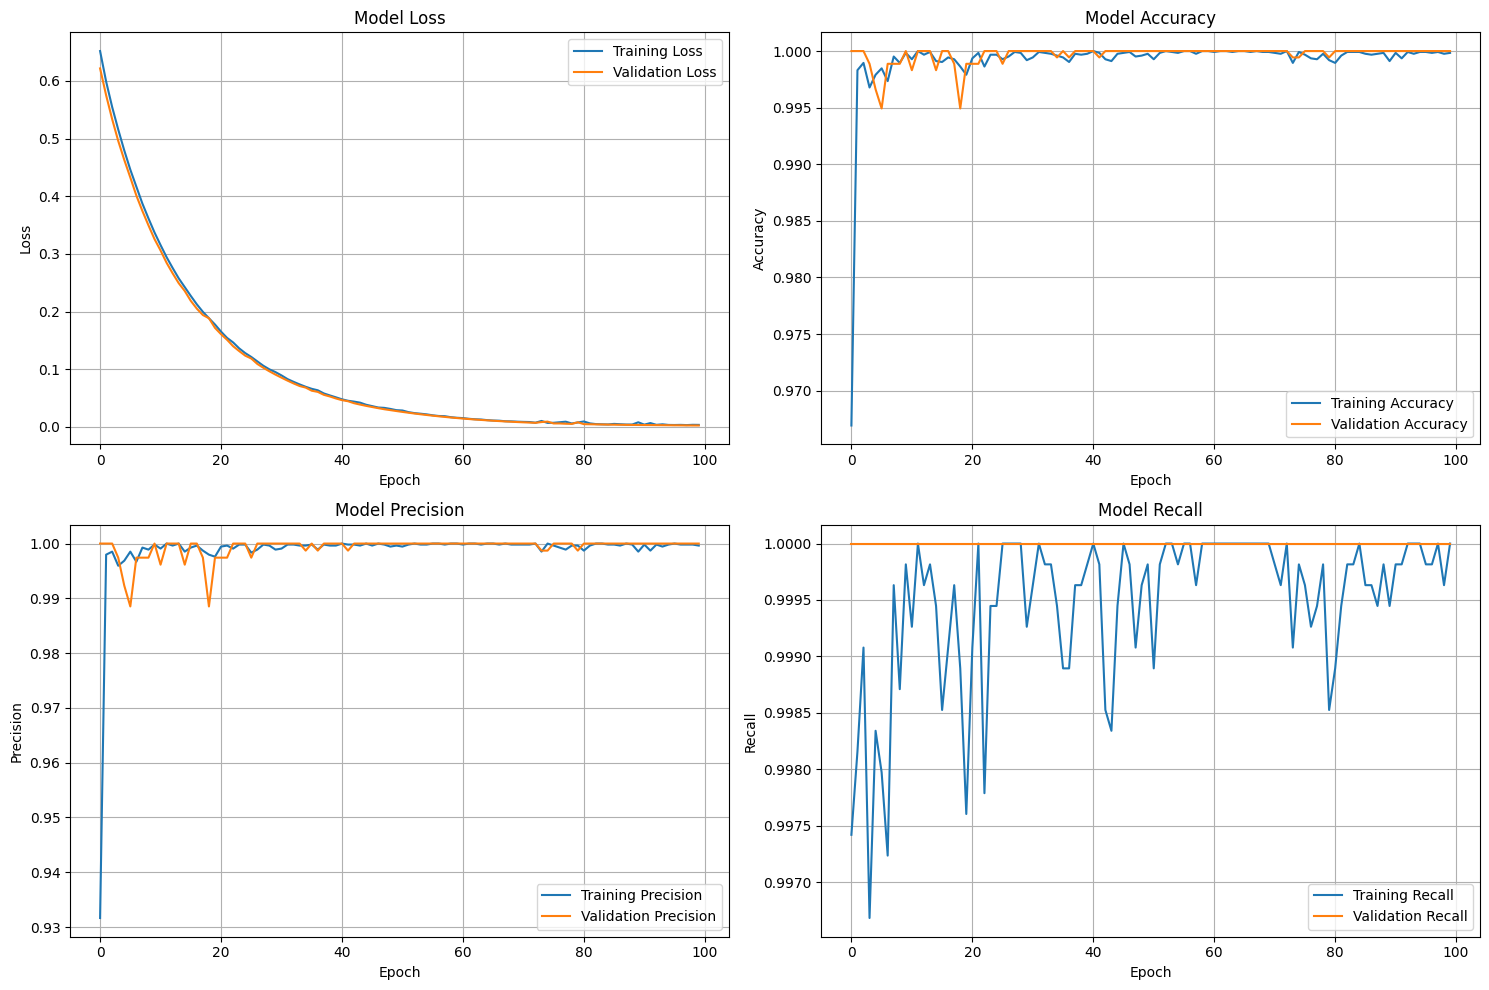

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Test Results:
Accuracy: 1.0000
AUC Score: 1.0000
Classification Report:
                  precision    recall  f1-score   support

Different Person       1.00      1.00      1.00      2000
     Same Person       1.00      1.00      1.00      1551

        accuracy                           1.00      3551
       macro avg       1.00      1.00      1.00      3551
    weighted avg       1.00      1.00      1.00      3551



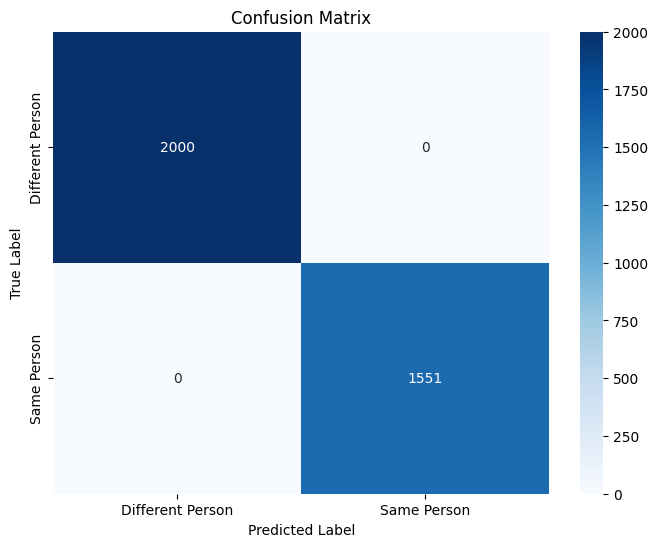

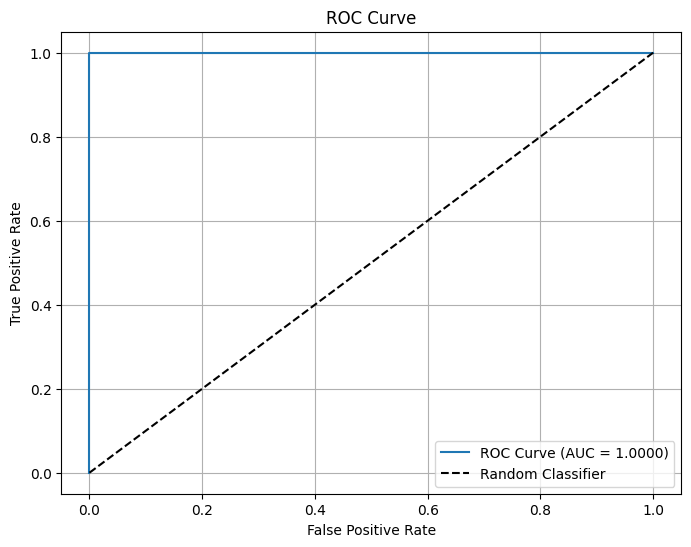

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Similarity: 0.0029


In [ ]:
#Train the model
siamese_network, results = train_siamese_network(features, pairs, labels)

#Make Predictions
sample1 = features.iloc[8].values
sample2 = features.iloc[10].values
similarity = siamese_network.predict_similarity(sample1, sample2)
print(f"Similarity: {similarity:.4f}")

#siamese_network.save_model('siamese_model.h5')

In [ ]:
similarity = compare_specific_samples(
    siamese_net=siamese_net,
    external_data=same_athlete,
    sample1_idx=1,
    sample2_idx=6
)

Similarity between sample 1 and 6: 0.5000
LOW similarity - Likely different person


In [ ]:
sample1 = same_athlete.iloc[10].values
sample2 = same_athlete.iloc[4].values
similarity = siamese_network.predict_similarity(sample1, sample2)
print(f"Similarity: {similarity:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Similarity: 0.9669


Athlete 1 = 25W111_L23_037; 25W53_L23_037; 25W64_L23_021
Athlete 2 =

In [ ]:
asame_athlete.iloc[1:9]

,mz_114.0650_rt_30.0,mz_116.9300_rt_5.0,mz_134.0600_rt_160.0,mz_135.0450_rt_205.0,mz_142.0650_rt_280.0,mz_144.0450_rt_145.0,mz_144.0450_rt_150.0,mz_151.0400_rt_205.0,mz_153.0900_rt_270.0,mz_154.0600_rt_25.0,...,mz_713.4200_rt_275.0,mz_731.2800_rt_65.0,mz_731.2800_rt_70.0,mz_740.4650_rt_280.0,mz_745.4200_rt_280.0,mz_814.8450_rt_150.0,mz_845.2450_rt_170.0,mz_873.3500_rt_120.0,mz_875.3600_rt_120.0,mz_924.3650_rt_230.0
sample_id,,,,,,,,,,,,,,,,,,,,,
25W112_L23_006,2.609639e+10,3602781.5,0.0,0.0,0.0,44103408.0,0.0,0.0,0.0,0.000000e+00,...,0.0,129528560.0,0.0,103128568.0,0.0,1.773678e+06,23752418.0,0.0,0.0,0.0
25W117_L23_018,3.429722e+10,4495395.0,0.0,0.0,203277808.0,80713432.0,0.0,24324228.0,0.0,0.000000e+00,...,0.0,265924768.0,0.0,101701648.0,0.0,5.441894e+06,64019668.0,0.0,0.0,8907219.0
25W33_L23_039,4.235935e+10,0.0,0.0,0.0,0.0,20860994.0,0.0,0.0,0.0,1.015507e+08,...,31929842.0,0.0,227155728.0,0.0,0.0,1.516660e+07,93372192.0,0.0,142622304.0,0.0
25W53_L23_037,3.106698e+10,2657968.5,0.0,0.0,0.0,0.0,34603536.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
25W64_L23_021,2.588003e+10,5149136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.610273e+08,...,0.0,0.0,124278344.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
25W71_409_R024,1.649916e+10,9040483.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.336046e+09,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,9093309.0,0.0,0.0
25W82_409_024,2.600659e+10,25949292.0,0.0,0.0,0.0,0.0,0.0,214542192.0,55137448.0,0.000000e+00,...,0.0,0.0,79560808.0,0.0,0.0,0.000000e+00,11191681.0,0.0,0.0,0.0
25W82_409_035,2.890373e+10,0.0,0.0,0.0,0.0,0.0,518539232.0,0.0,113171552.0,0.000000e+00,...,0.0,0.0,74087544.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0


In [ ]:
ids = ids['sample_id']